# Further Evaluation: Discord Spam Detector

### Tamara Frances
<br>

---
<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from wordcloud import WordCloud, STOPWORDS


In [2]:
df = pd.read_excel('../data/data-for-capstone.xlsx')
df.columns = df.columns.str.lower()
df = df.rename(columns={'spam?':'spam'})

<br>

### Multinomial Naive Bayes with Gridseach - Imbalanced Data

In [3]:
X = df['text']
y = df['spam']
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify = y, random_state=42)

cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

mnb = MultinomialNB()
mnb.fit(X_train_cv, y_train)
print('train score:',mnb.score(X_train_cv, y_train), ', test score:',mnb.score(X_test_cv, y_test))

pipeline = Pipeline([
    ('cv', CountVectorizer(stop_words='english')),
    ('mnb', MultinomialNB())
])

parameters = {
    'cv__min_df': (1,2,3),
    'cv__ngram_range': ((1, 1), (1, 2), (2,2)),
    'mnb__alpha': [0.01, 0.05, 0.1]
}
    
gs_mnb = GridSearchCV(pipeline, param_grid = parameters, n_jobs=-1)
gs_mnb.fit(X_train, y_train);

print('The accuracy score with hyperparameter tuning increased by : '
      f'{round((gs_mnb.score(X_test, y_test)) - (mnb.score(X_test_cv, y_test)),4)}')

train score: 0.9925595238095238 , test score: 0.9288888888888889
The accuracy score with hyperparameter tuning increased by : -0.0044


In [4]:
print('best params : ', gs_mnb.best_params_)
print('best estimator : ', gs_mnb.best_estimator_)

best params :  {'cv__min_df': 1, 'cv__ngram_range': (1, 1), 'mnb__alpha': 0.1}
best estimator :  Pipeline(steps=[('cv', CountVectorizer(stop_words='english')),
                ('mnb', MultinomialNB(alpha=0.1))])


Classification Report:
              precision    recall  f1-score   support

           N       0.97      0.94      0.96       194
           Y       0.69      0.81      0.75        31

    accuracy                           0.92       225
   macro avg       0.83      0.87      0.85       225
weighted avg       0.93      0.92      0.93       225



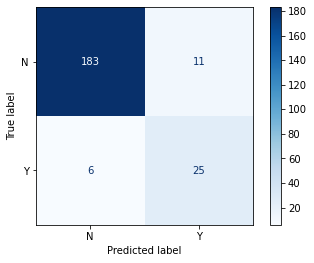

In [5]:
cr_mnb = classification_report(y_test, gs_mnb.predict(X_test))
print("Classification Report:")
print(cr_mnb)

ConfusionMatrixDisplay.from_estimator(gs_mnb, X_test, y_test, cmap='Blues');

<br>
<br>

---

<br>
<br>

<br>

### Misclassifications

In [6]:
test_preds = gs_mnb.predict(X_test)
pd.set_option('display.max_colwidth', None)

In [7]:
misclassifications = pd.DataFrame(X_test)

misclassifications['pred class'] = test_preds
misclassifications['true class'] = y_test

mis = misclassifications[misclassifications['pred class'] != misclassifications['true class']]
mis

,text,pred class,true class
376,Wow .25 is mint,Y,N
339,Paid for my nft several times over between giveaways and wl spots,Y,N
719,sheesh thats dope,Y,N
601,Lets say you can buy PAYPAL BALANCE too!,N,Y
829,Is sneaker con an event you pay to get into? So people really paying to pay resell?,Y,N
27,Ended up refunding the game,Y,N
560,Biggest NFT project in the world valued at $4bn,Y,N
596,"For Mobile minting, Please use Metamask App built-in Browser to mint. Copy the link and paste into the browser in metamask app to mint.",N,Y
546,Hello Can you change telegram in coincapmarket ?,Y,N
489,All it took before was 1 day to get from .002 back to .01,Y,N


I'm not surprised that most of the misclassifications involve NFTs or cryptocurrency in some way since most of the spam involved these terms.
<br><br>

In [8]:
text = ' '.join(misclassifications['text'])
wordcloud = WordCloud(stopwords = STOPWORDS,width=1000, height=400, min_font_size = 12, max_font_size=200, max_words=40,
                      background_color="white",
                      colormap = 'gist_heat',
                      min_word_length = 3).generate(text) #get rid of smaller words/parts of contractions that aren't descriptive

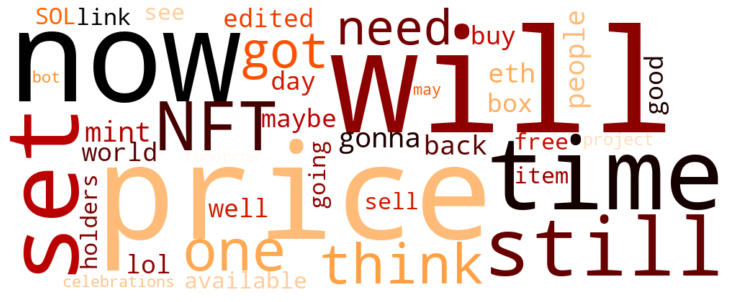

In [9]:
plt.figure(figsize=(12,4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()